# Dùng mô hình học máy để dự đoán

In [1]:
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, expr, col, column
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Stocks-price-Prediction") \
    .master("spark://spark-master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

print(spark.version)

25/10/25 03:47:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.1.1


In [3]:
df = spark.read.csv("hdfs://namenode:9000/datack/FPT.csv", header=True, inferSchema=True)
df.show(5)

+----------+-----+-----+-----+-----+-------+
|      time| open| high|  low|close| volume|
+----------+-----+-----+-----+-----+-------+
|2020-01-06|20.84|21.03|20.74|20.81|1091660|
|2020-01-07|20.92|21.21|20.81|21.21| 837240|
|2020-01-08|20.99|21.06|20.74|20.74|1814290|
|2020-01-09|20.92|21.06|20.84|21.03| 967050|
|2020-01-10|20.99| 21.1|20.84|20.99|1018650|
+----------+-----+-----+-----+-----+-------+
only showing top 5 rows



In [4]:
df = df.withColumn("mean", expr('(high+low)/2'))
df.show(5)

+----------+-----+-----+-----+-----+-------+------------------+
|      time| open| high|  low|close| volume|              mean|
+----------+-----+-----+-----+-----+-------+------------------+
|2020-01-06|20.84|21.03|20.74|20.81|1091660|20.884999999999998|
|2020-01-07|20.92|21.21|20.81|21.21| 837240|21.009999999999998|
|2020-01-08|20.99|21.06|20.74|20.74|1814290|              20.9|
|2020-01-09|20.92|21.06|20.84|21.03| 967050|             20.95|
|2020-01-10|20.99| 21.1|20.84|20.99|1018650|             20.97|
+----------+-----+-----+-----+-----+-------+------------------+
only showing top 5 rows



In [5]:
asc_df = df.sort(df.time.asc()) #Sắp xếp các cột theo tứ tự tăng dần của thời gian
asc_df.show(5)

+----------+-----+-----+-----+-----+-------+------------------+
|      time| open| high|  low|close| volume|              mean|
+----------+-----+-----+-----+-----+-------+------------------+
|2020-01-06|20.84|21.03|20.74|20.81|1091660|20.884999999999998|
|2020-01-07|20.92|21.21|20.81|21.21| 837240|21.009999999999998|
|2020-01-08|20.99|21.06|20.74|20.74|1814290|              20.9|
|2020-01-09|20.92|21.06|20.84|21.03| 967050|             20.95|
|2020-01-10|20.99| 21.1|20.84|20.99|1018650|             20.97|
+----------+-----+-----+-----+-----+-------+------------------+
only showing top 5 rows



In [6]:
df_test = asc_df.filter(year("time") > 2024)
df_test.show(5)

+----------+------+------+------+------+-------+------------------+
|      time|  open|  high|   low| close| volume|              mean|
+----------+------+------+------+------+-------+------------------+
|2025-01-02|131.49|131.66|129.42|131.06|3179535|            130.54|
|2025-01-03|130.45|130.45|128.47|128.47|4342125|129.45999999999998|
|2025-01-06|128.56| 129.5|127.95|128.73|3472044|           128.725|
|2025-01-07| 128.9|130.45| 128.9|129.42|3458671|           129.675|
|2025-01-08|129.33|129.33|127.69|127.87|3886957|            128.51|
+----------+------+------+------+------+-------+------------------+
only showing top 5 rows



In [7]:
df_train = asc_df.subtract(df_test)   #tách ra tập train
df_train.count()

1248

In [8]:
df_train = df_train.sort(df_train.time.asc())   #sắp xếp lại tập train
df_train.show(5)
dataset_train = df_train.toPandas()

+----------+-----+-----+-----+-----+-------+------------------+
|      time| open| high|  low|close| volume|              mean|
+----------+-----+-----+-----+-----+-------+------------------+
|2020-01-06|20.84|21.03|20.74|20.81|1091660|20.884999999999998|
|2020-01-07|20.92|21.21|20.81|21.21| 837240|21.009999999999998|
|2020-01-08|20.99|21.06|20.74|20.74|1814290|              20.9|
|2020-01-09|20.92|21.06|20.84|21.03| 967050|             20.95|
|2020-01-10|20.99| 21.1|20.84|20.99|1018650|             20.97|
+----------+-----+-----+-----+-----+-------+------------------+
only showing top 5 rows



In [9]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from sklearn.preprocessing import MinMaxScaler

# Import thư viện PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [11]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout_rate=0.2):
        super(LSTMRegressor, self).__init__()
        
        # Lớp LSTM 1 (tương đương units=50, return_sequences=True)
        # batch_first=True giúp input có dạng (batch_size, seq_len, features)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Lớp LSTM 2 (tương đương units=50, return_sequences=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Lớp LSTM 3 (tương đương units=50, return_sequences=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Lớp LSTM 4 (tương đương units=50, return_sequences=False)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Lớp Dense (tương đương Dense(units=1))
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # PyTorch LSTM trả về (output, (hidden_state, cell_state))
        
        # Layer 1
        # Keras tự động khởi tạo hidden state. PyTorch cũng vậy (mặc định là zeros).
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        # Layer 2
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        # Layer 3
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        
        # Layer 4
        # out có shape (batch_size, seq_len, hidden_size)
        out, _ = self.lstm4(out)
        
        # Tương đương return_sequences=False, ta chỉ lấy output của time step cuối cùng
        # out[:, -1, :] lấy ra (batch_size, hidden_size)
        out = self.dropout4(out[:, -1, :])
        
        # Lớp Linear/Dense
        out = self.fc(out)
        return out

In [12]:
# Thuc hien scale du lieu gia ve khoang 0,1
training_set = dataset_train.iloc[:, 6:7].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Tạo dữ liệu train
X_train = []
y_train = []
no_of_sample = len(training_set_scaled) # Sửa: dùng training_set_scaled

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape cho Keras (batch_size, timesteps, features)
# PyTorch với batch_first=True cũng dùng shape này
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_tensor = torch.from_numpy(X_train).float().to(device)
# y_train cần reshape thành (batch_size, 1) cho hàm loss
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1).to(device)

# Tạo DataLoader để xử lý batch
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
model = LSTMRegressor(input_size=1, hidden_size=50, dropout_rate=0.2).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters())

MODEL_PATH = "mymodel.pth"

if path.exists(MODEL_PATH):
    # Load model state_dict
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Loaded model weights from {MODEL_PATH}")
else:
    print(f"No model found. Starting training for 100 epochs...")
    epochs = 100
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad() # Xóa gradient của vòng lặp trước
            loss.backward()       # Tính toán gradient
            optimizer.step()      # Cập nhật trọng số
            
            epoch_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
            
    # Lưu model state_dict
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Training complete. Saved model to {MODEL_PATH}")

No model found. Starting training for 100 epochs...
Epoch [10/100], Loss: 0.0020
Epoch [20/100], Loss: 0.0015
Epoch [30/100], Loss: 0.0014
Epoch [40/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0007
Training complete. Saved model to mymodel.pth


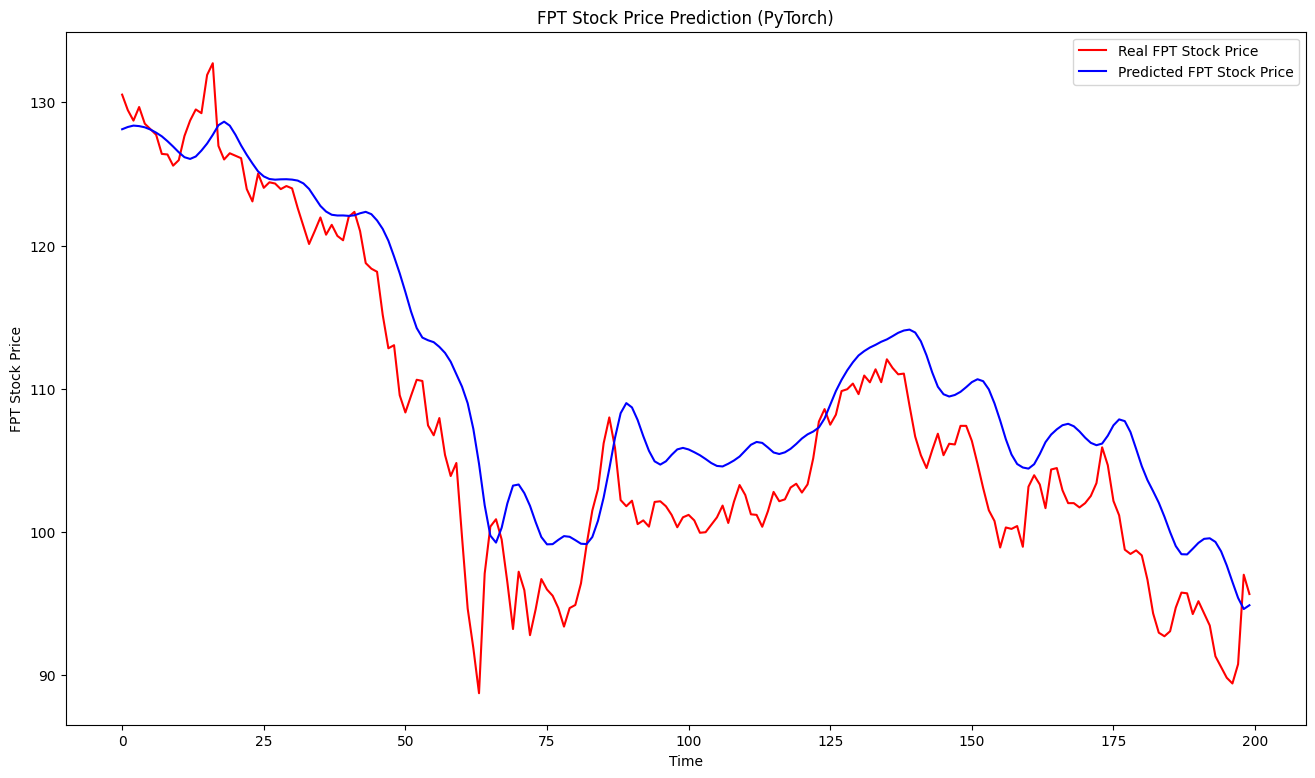

In [15]:
dataset_test = df_test.toPandas()
real_stock_price = dataset_test.iloc[:, 6:7].values

dataset_total = pd.concat((dataset_train['mean'], dataset_test['mean']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample_test = len(inputs) # Sửa tên biến

for i in range(60, no_of_sample_test):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test_tensor = torch.from_numpy(X_test).float().to(device)

model.eval()

with torch.no_grad():
    predicted_stock_price_tensor = model(X_test_tensor)

predicted_stock_price_numpy = predicted_stock_price_tensor.cpu().numpy()

predicted_stock_price = sc.inverse_transform(predicted_stock_price_numpy)

plt.figure(figsize=(16,9))
plt.plot(real_stock_price, color = 'red', label = 'Real FPT Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction (PyTorch)')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

print("Đánh giá mô hình trên tập Test")

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

mape = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f} %')

Đánh giá mô hình trên tập Test
Root Mean Squared Error (RMSE): 4.9366
Mean Absolute Percentage Error (MAPE): 3.97 %


In [18]:
print("\nDự đoán cho các ngày tiếp theo")

n_future_days = 10 
last_60_days_scaled = inputs[-60:]
model.eval()
future_predictions_scaled = []

with torch.no_grad():
    for _ in range(n_future_days):
        input_tensor = torch.from_numpy(last_60_days_scaled).float().reshape(1, 60, 1).to(device)
        next_pred_scaled = model(input_tensor) 
        future_predictions_scaled.append(next_pred_scaled.item())
        new_row = next_pred_scaled.cpu().numpy()
        last_60_days_scaled = np.append(last_60_days_scaled[1:], new_row, axis=0)

future_predictions = sc.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

print(f"Dự đoán giá Trung bình cho {n_future_days} ngày tiếp theo:")
for i, price in enumerate(future_predictions):
    print(f'Ngày {24+i}/10/2025: {price[0]:.2f}')


Dự đoán cho các ngày tiếp theo
Dự đoán giá Trung bình cho 10 ngày tiếp theo:
Ngày 24/10/2025: 96.01
Ngày 25/10/2025: 97.52
Ngày 26/10/2025: 99.05
Ngày 27/10/2025: 100.44
Ngày 28/10/2025: 101.69
Ngày 29/10/2025: 102.84
Ngày 30/10/2025: 103.93
Ngày 31/10/2025: 104.98
Ngày 32/10/2025: 106.01
Ngày 33/10/2025: 107.02


In [19]:
spark.stop()